# Julia Draw Something

In [1]:
using DataFrames
using TensorFlow
using Distributions
using Images

I tensorflow/stream_executor/dso_loader.cc:125] successfully opened CUDA library libcublas.so.8.0 locally
I tensorflow/stream_executor/dso_loader.cc:116] Couldn't open CUDA library libcudnn.so.5. LD_LIBRARY_PATH: /usr/local/cuda/lib64
I tensorflow/stream_executor/cuda/cuda_dnn.cc:3459] Unable to load cuDNN DSO
I tensorflow/stream_executor/dso_loader.cc:125] successfully opened CUDA library libcufft.so.8.0 locally
I tensorflow/stream_executor/dso_loader.cc:125] successfully opened CUDA library libcuda.so.1 locally
I tensorflow/stream_executor/dso_loader.cc:125] successfully opened CUDA library libcurand.so.8.0 locally
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUDA library libcublas.so locally
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUDA library libcudnn.so locally
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUDA library libcufft.so locally
I tensorflow/stream_executor/dso_loader.cc:128] successfully opened CUD

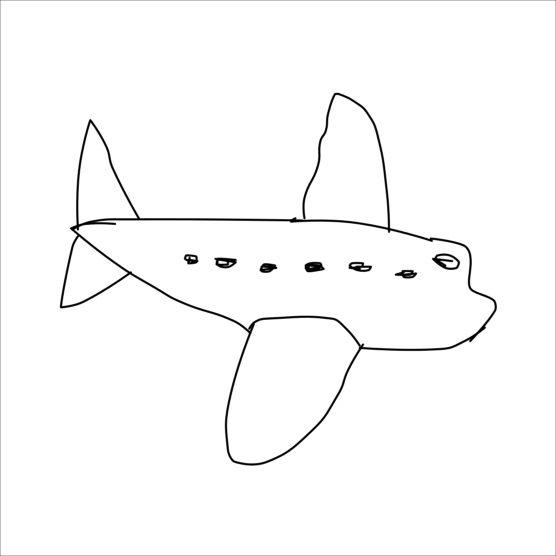

In [2]:
img = load("/raided/datasets/sketches_png/png/airplane/1.png")

In [3]:
data_set_folder = "/raided/datasets/sketches_png/png/"
list_of_imgs = open(data_set_folder * "filelist.txt")
img_paths = readlines(list_of_imgs)
close(list_of_imgs)

In [4]:
files_in_folder = readdir(data_set_folder)
labels = filter(x->isdir(data_set_folder * x) == true, files_in_folder)

250-element Array{String,1}:
 "airplane"     
 "alarm clock"  
 "angel"        
 "ant"          
 "apple"        
 "arm"          
 "armchair"     
 "ashtray"      
 "axe"          
 "backpack"     
 "banana"       
 "barn"         
 "baseball bat" 
 ⋮              
 "umbrella"     
 "van"          
 "vase"         
 "violin"       
 "walkie talkie"
 "wheel"        
 "wheelbarrow"  
 "windmill"     
 "wine-bottle"  
 "wineglass"    
 "wrist-watch"  
 "zebra"        

In [5]:
x = TensorFlow.placeholder(Float32)
y_ = TensorFlow.placeholder(Float32)
W = get_variable("weights", [77841, 10], Float32)
b = get_variable("bias", [10], Float32)

TensorFlow.Variable(<Operation 'bias'>,<Operation 'bias/Assign'>)

In [6]:
y = nn.softmax(x*W + b)
cross_entropy = reduce_mean(-reduce_sum(y_ .* log(y), reduction_indices=[2]))
train_step = train.minimize(train.GradientDescentOptimizer(.00001), cross_entropy)

W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use FMA instructions, but these are available on your machine and could speed up CPU computations.


<Tensor NoOp:1 shape=unknown dtype=?>

In [7]:
type DataLoader
    cur_id::Int
    order::Vector{Int}
    count::Int
end

TrainLoader() = DataLoader(1, (1:350), 0)

TrainLoader (generic function with 1 method)

In [8]:
function next_batch(loader::DataLoader, batch_size)
    x = zeros(Float32, batch_size, 77841)
    y = zeros(Float32, batch_size, 10)
    for i = 1:batch_size
        path = img_paths[loader.cur_id][1:end-1]
        sketch_name = split(path, "/")[1]
        img = load(data_set_folder * path)
        img = restrict(restrict(img))
        flatten_img = reshape(img, 77841)
        
        x[i, :] = flatten_img
        label = find((x -> x == sketch_name), labels)[1]
        y[i, label] = 1.0
        loader.cur_id += 1
        loader.count += 1
        if loader.cur_id > 400
            loader.cur_id = 1
            break
        elseif loader.count % 70 == 0
            loader.cur_id += 10
            loader.count = 0
        end
    end
    x, y
end

next_batch (generic function with 1 method)

In [9]:
TestLoader() = DataLoader(71, (1:50), 0)

function get_test(loader::DataLoader)
    x = zeros(Float32, 50, 77841)
    y = zeros(Float32, 50, 10)
    for i = 1:50
        path = img_paths[loader.cur_id][1:end-1]
        sketch_name = split(path, "/")[1]
        img = load(data_set_folder * path)
        img = restrict(restrict(img))
        flatten_img = reshape(img, 77841)
        
        x[i, :] = flatten_img
        label = find((x -> x == sketch_name), labels)[1]
        y[i, label] = 1.0
        loader.cur_id += 1
        loader.count += 1
        if loader.cur_id > 400
            loader.cur_id = 1
            break
        elseif loader.count % 10 == 0
            println("========================")
            println(sketch_name)
            loader.cur_id += 70
            loader.count = 0
            if loader.cur_id > 400
                break
                
            end
        end
    end
    x, y
end

get_test (generic function with 1 method)

In [10]:
loader = TrainLoader()
sess = Session()
run(sess, initialize_all_variables())
for i in 1:35
    batch = next_batch(loader, 10)
    run(sess, train_step, Dict(x=>batch[1], y_=>batch[2]))
    println("DONE BATCH ", i)
end

DONE BATCH 1
DONE BATCH 

I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:910] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I tensorflow/core/common_runtime/gpu/gpu_device.cc:885] Found device 0 with properties: 
name: GeForce GTX 1070
major: 6 minor: 1 memoryClockRate (GHz) 1.683
pciBusID 0000:01:00.0
Total memory: 7.92GiB
Free memory: 7.40GiB
I tensorflow/core/common_runtime/gpu/gpu_device.cc:906] DMA: 0 
I tensorflow/core/common_runtime/gpu/gpu_device.cc:916] 0:   Y 
I tensorflow/core/common_runtime/gpu/gpu_device.cc:975] Creating TensorFlow device (/gpu:0) -> (device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0)


2
DONE BATCH 3
DONE BATCH 4
DONE BATCH 5
DONE BATCH 6
DONE BATCH 7
DONE BATCH 8
DONE BATCH 9
DONE BATCH 10
DONE BATCH 11
DONE BATCH 12
DONE BATCH 13
DONE BATCH 14
DONE BATCH 15
DONE BATCH 16
DONE BATCH 17
DONE BATCH 18
DONE BATCH 19
DONE BATCH 20
DONE BATCH 21
DONE BATCH 22
DONE BATCH 23
DONE BATCH 24
DONE BATCH 25
DONE BATCH 26
DONE BATCH 27
DONE BATCH 28
DONE BATCH 29
DONE BATCH 30
DONE BATCH 31
DONE BATCH 32
DONE BATCH 33
DONE BATCH 34


In [11]:
correct_prediction = indmax(y, 2) .== indmax(y_, 2)
accuracy=reduce_mean(cast(correct_prediction, Float64))
test_loader = TestLoader()
testx, testy = get_test(test_loader)

println(run(sess, accuracy, Dict(x=>testx, y_=>testy)))

--------------------
airplane
71
--------------------
airplane
72
--------------------
airplane
73
--------------------
airplane
74
--------------------
airplane
75
--------------------
airplane
76
--------------------
airplane
77
--------------------
airplane
78
--------------------
airplane
79
--------------------
airplane
80
--------------------
alarm clock
151
--------------------
alarm clock
152
--------------------
alarm clock
153
--------------------
alarm clock
154
--------------------
alarm clock
155
--------------------
alarm clock
156
--------------------
alarm clock
157
--------------------
alarm clock
158
--------------------
alarm clock
159
--------------------
alarm clock
160
--------------------
angel
231
--------------------
angel
232
--------------------
angel
233
--------------------
angel
234
--------------------
angel
235
--------------------
angel
236
--------------------
angel
237
--------------------
angel
238
--------------------
angel
239
--------------------
